In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json

plt.style.use('plot_style.txt')

In [2]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"

In [3]:
def process_ts_results(result_dir: str,
                       num_runs: int,
                       failure_val: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [4]:
def process_original_albo_results(result_dir: str,
                                  num_runs: int,
                                  failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            all_results.append(run_results)
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [14]:
original_albo_no_slack_results, original_albo_no_slack_results_mean, original_albo_no_slack_results_median, original_albo_no_slack_results_std = process_original_albo_results("../results/final_original_results/lockwood/no_slack/data/", 20, 6)
original_albo_slack_optim_results, original_albo_slack_optim_results_mean, original_albo_slack_optim_results_median, original_albo_slack_optim_results_std = process_original_albo_results("../results/final_original_results/lockwood/slack_optim/data/", 20, 6)
original_albo_slack_no_optim_results, original_albo_slack_no_optim_results_mean, original_albo_slack_no_optim_results_median, original_albo_slack_no_optim_results_std = process_original_albo_results("../results/final_original_results/lockwood/slack_no_optim/data/", 20, 6)
random_results, random_results_mean, random_results_median, random_results_std = process_ts_results("../results/20-04-23/lockwood_random/data/", 20, 6)
ts_al_adam_results, ts_al_adam_results_mean, ts_al_adam_results_median, ts_al_adam_results_std = process_ts_results("../results/final_ts_results/lockwood/adam/data/", 20, 6)
ts_al_adam_no_prev_results, ts_al_adam_no_prev_results_mean, ts_al_adam_no_prev_results_median, ts_al_adam_no_prev_results_std = process_ts_results("../results/final_ts_results/lockwood/adam_no_prev/data/", 20, 6)
ts_reduced_lbfgs_results, ts_reduced_lbfgs_results_mean, ts_reduced_lbfgs_results_median, ts_reduced_lbfgs_results_std = process_ts_results("../results/24-04-23/lockwood_6000_samples_2_bfgs/data/", 6, 6)
# Don't think below used zero mean
ts_no_optim_results, ts_no_optim_results_mean, ts_no_optim_results_median, ts_no_optim_results_std = process_ts_results("../results/25-04-23/lockwood_no_optim/data/", 20, 6)

In [15]:
print(ts_al_adam_no_prev_results[:, -1])

[2.660598 2.83604  2.727703 2.682446 2.602761 2.597468 2.868175 2.90067
 2.755453 2.715159 2.722532 2.732875 2.774722 2.731689 2.97937  2.51004
 2.672139 2.78606  2.753622 2.915041]


In [16]:
print(ts_al_adam_results[:, -1])

[2.870504 2.902506 2.75202  2.767581 2.75646  2.80701  2.721786 2.636528
 2.907329 2.771376 2.748414 2.610209 2.990099 2.664932 2.700597 2.600719
 2.662489 2.849072 2.728561 2.703057]


In [19]:
print(np.mean(ts_al_adam_no_prev_results[:, -1]))

2.7462281500000003


In [20]:
print(np.mean(ts_al_adam_results[:, -1]))

2.7575624500000004


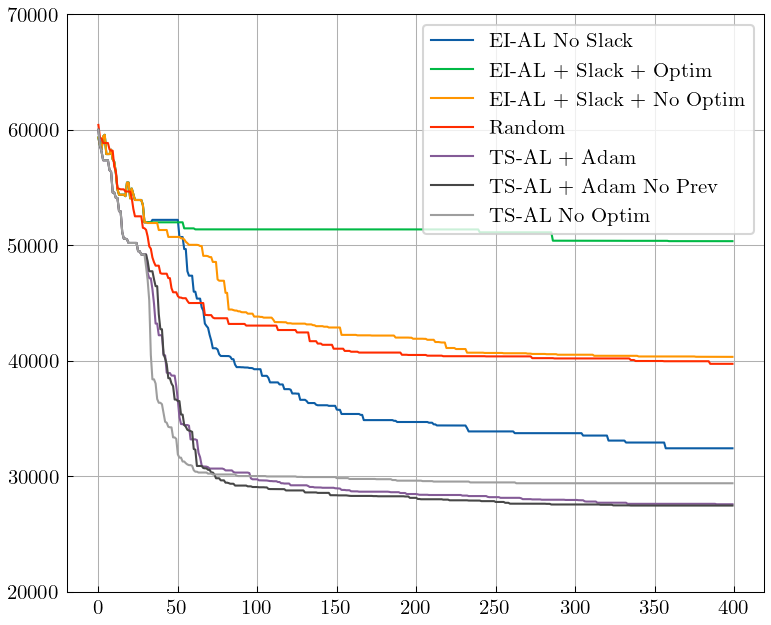

In [22]:
plt.figure(figsize=(6,5))
plt.plot(original_albo_no_slack_results_mean * 10000, label="EI-AL No Slack")
plt.plot(original_albo_slack_optim_results_mean * 10000, label="EI-AL + Slack + Optim")
plt.plot(original_albo_slack_no_optim_results_mean * 10000, label="EI-AL + Slack + No Optim")
plt.plot(random_results_mean[:400] * 10000, label="Random")
plt.plot(ts_al_adam_results_mean * 10000, label="TS-AL + Adam")
plt.plot(ts_al_adam_no_prev_results_mean * 10000, label="TS-AL + Adam No Prev")
# plt.plot(ts_results_mean * 10000)
# plt.plot(ts_reduced_lbfgs_results_mean[:400] * 10000, label="TS-AL + L-BFGS-B")
plt.plot(ts_no_optim_results_mean[:400] * 10000, label="TS-AL No Optim")
plt.ylim(20000, 70000)
plt.legend()